In [ ]:
import tensorflow as tf
import os
import numpy as np
import cv2 as cv
import random
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, InputLayer, concatenate, Conv2D, MaxPooling2D, Flatten, Dense, UpSampling2D, Reshape, Dropout, Activation, Permute
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model as plot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
import pandas as pd
print(tf.__version__)

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=False)

#Installing and logging into Wandb

In [ ]:
!pip install --upgrade wandb
!wandb login #Enter wandb login

#Paths

In [ ]:
drive_path = '/content/drive/My Drive/DRProjectData/'
trainds_path = '/IDRID_Datasets/Disease_Grading/Groundtruths/'
testds_path = '/IDRID_Datasets/Disease_Grading/Groundtruths/'
train_img_dir = '/IDRID_Datasets/Disease_Grading/Original_Images/Training_Set/'
test_img_dir = '/IDRID_Datasets/Disease_Grading/Original_Images/Testing_Set'

#CSV to Pandas Dataframe

In [ ]:
#train_file = 'DR_Grading_Training Labels.csv'
train_file = 'DR_Binary_Training Labels.csv'

#test_file = 'DR_Grading_Testing Labels.csv'
test_file = 'DR_Binary_Testing Labels.csv'

traindf = pd.read_csv(drive_path + trainds_path + train_file, dtype=str)
traindf['Image name'] = traindf['Image name'].astype(str) + '.jpg'
testdf = pd.read_csv(drive_path + testds_path + test_file, dtype=str)
testdf['Image name'] = testdf['Image name'].astype(str) + '.jpg'
len(traindf)

413

In [ ]:
traindf.tail(20)

In [ ]:
testdf.tail(20)

#Hyperparameters

In [ ]:
train_batch_size = 8
valid_batch_size = 8
test_batch_size = 8
img_size = 224

#Train ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                       horizontal_flip=True)#, validation_split = 0.20)

train_generator = train_datagen.flow_from_dataframe(
    dataframe = traindf,
    directory = drive_path + train_img_dir,#img_train_path, #drive_path + train_img_dir,
    x_col = 'Image name',
    y_col = 'Retinopathy grade',
    #subset = 'training',
    target_size = (img_size,img_size),
    class_mode = 'binary',
    batch_size = train_batch_size,
    shuffle = True
)



Found 413 validated image filenames belonging to 2 classes.


#Test ImageDataGenerator

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255.)# , validation_split = 0.20)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = testdf,
    directory = drive_path + test_img_dir,#img_train_path, #drive_path + train_img_dir,
    x_col = 'Image name',
    y_col = 'Retinopathy grade',
    #subset = 'training',
    target_size = (img_size,img_size),
    class_mode = 'binary',
    batch_size = test_batch_size,
    shuffle = True
)

Found 103 validated image filenames belonging to 2 classes.


#Defining Neural Network Model

In [ ]:
def NNmodel():
  model = tf.keras.models.Sequential([
    #CONV1
    Conv2D(64, (3,3), activation='relu', padding ='same', input_shape=(img_size,img_size, 3)),
    Conv2D(64, (3,3), activation='relu', padding ='same'),
    MaxPooling2D(2,2),
    #Dropout(0.5),
    #CONV2
    Conv2D(128, (3,3), activation='relu', padding ='same'),
    Conv2D(128, (3,3), activation='relu', padding ='same'),
    MaxPooling2D(2,2),
    #Dropout(0.5),
    #CONV3
    Conv2D(256, (3,3), activation='relu', padding ='same'),
    Conv2D(256, (3,3), activation='relu', padding ='same'),
    Conv2D(256, (3,3), activation='relu', padding ='same'),
    Conv2D(256, (3,3), activation='relu', padding ='same'),
    Conv2D(256, (3,3), activation='relu', padding ='same'),
    MaxPooling2D(2,2),
    #Dropout(0.5),    
    #CONV4
    Conv2D(512, (3,3), activation='relu', padding ='same'),
    Conv2D(512, (3,3), activation='relu', padding ='same'),
    Conv2D(512, (3,3), activation='relu', padding ='same'),
    Conv2D(512, (3,3), activation='relu', padding ='same'),
    Conv2D(512, (3,3), activation='relu', padding ='same'),
    MaxPooling2D(2,2),
    #Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
  model.summary()
  model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
  return model

In [ ]:
model = NNmodel()

#Configuring Wandb project

In [ ]:
import wandb
wandb.init(project="diabetic_retinopathy_binary1", name='train-16cnn-idrid', sync_tensorboard=True)

#Callback, Checkpoints and Early stopping

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>=0.7500):
      print("\nReached 75.00% validation accuracy so cancelling training!")
      self.model.stop_training = True
callbacks1 = myCallback()

In [ ]:
checkpoint = ModelCheckpoint("/content/model2_best.hdf5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='max', save_freq="epoch")

In [ ]:
earlystop = EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=5, verbose=1, mode='max',
    baseline=None, restore_best_weights=False
)

In [ ]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=wandb.run.dir),
    checkpoint,
    callbacks1,
    earlystop,
    wandb.keras.WandbCallback()
]

#Training the model and saving metrics to history

In [ ]:
history = model.fit(train_generator,
                    validation_data = test_generator,
                    steps_per_epoch = train_generator.samples//train_batch_size,
                    epochs =  100,
                    validation_steps = test_generator.samples//valid_batch_size,
                    verbose = 1,
                    callbacks = [callbacks]
                    #callbacks = [callbacks1]
                    )

#Saving the best weights

In [ ]:
model.save(drive_path+'IDRID_Model_iter0100.h5')

#Visualizing the model's inner layers

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


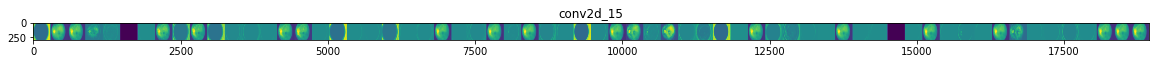

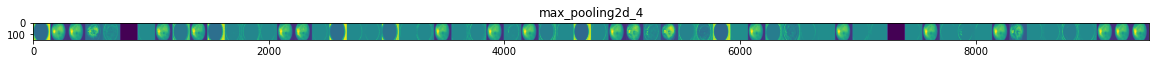

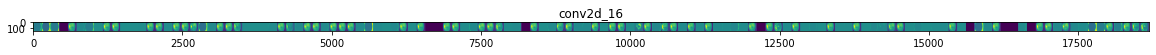

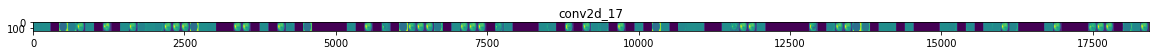

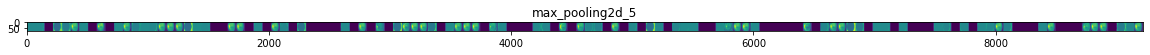

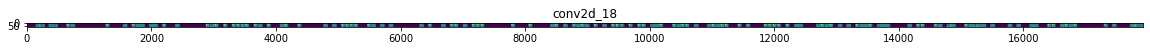

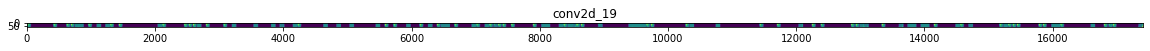

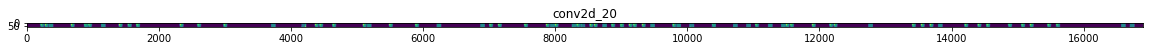

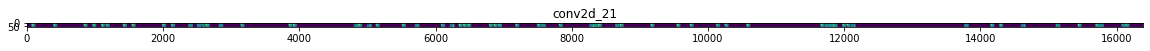

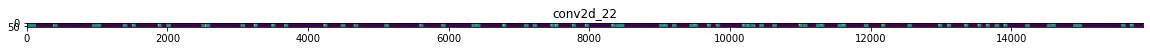

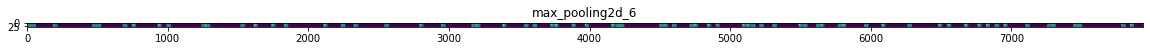

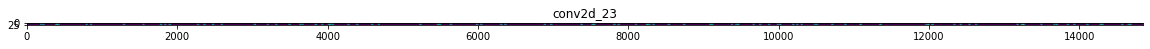

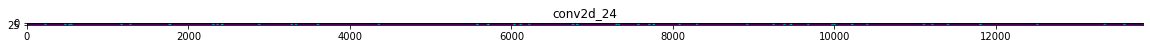

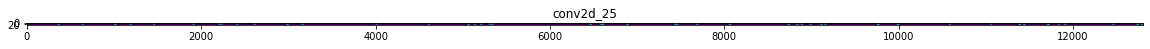

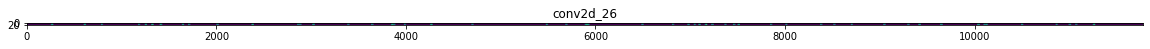

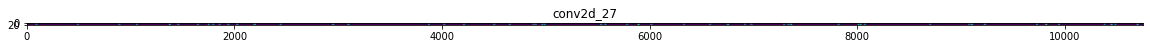

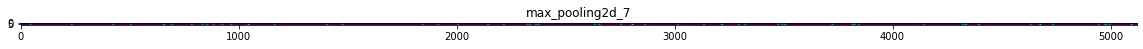

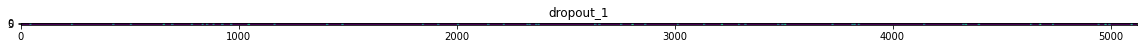

In [ ]:
# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
img_path = random.choice(rand_img_files)

img = load_img(img_path, target_size=(300, 300))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers[1:]]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i] 
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

#Running inference on random images

In [ ]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(300, 300))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " Presence of DR detected")
  else:
    print(fn + " No DR Detected")

#Evaluation on test set

In [ ]:
model_eval = load_model('/content/best_model.hdf5')
hist_eval = model_eval.evaluate(
    test_generator,
    verbose = 1,
)
print(hist_eval)